In [2]:
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
with open('data/friends-000______.txt') as f, open("data/output.txt", "w") as w:
    for row in f:
        if 'private' not in row and 'notfound' not in row:
            row = row.replace(",", " ")
            row = row.replace(":", " ")
            w.write(row)

In [4]:
w.close()

In [5]:
G = nx.read_adjlist('data/output.txt')

In [6]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 3051181
Number of edges: 10724270
Average degree:   7.0296


In [7]:
list(G)

['102',
 '101',
 '181',
 '794',
 '798',
 '804',
 '811',
 '814',
 '821',
 '996',
 '6319',
 '6533',
 '40495',
 '148648',
 '861441',
 '967502',
 '1064745',
 '1077747',
 '2806491',
 '9229534',
 '17838679',
 '104',
 '1143',
 '628701',
 '2438054',
 '107',
 '134',
 '385',
 '386',
 '520',
 '634835',
 '834879',
 '2743054',
 '13312740',
 '112',
 '113',
 '398234',
 '429887',
 '3901400',
 '18449866',
 '23921615',
 '349',
 '98405',
 '1184372',
 '1621447',
 '2167080',
 '2425437',
 '9573889',
 '9738716',
 '18283313',
 '116',
 '140',
 '117',
 '307',
 '23132932',
 '120',
 '121',
 '4315',
 '160253',
 '264724',
 '265042',
 '329789',
 '359849',
 '391664',
 '658420',
 '667648',
 '1252938',
 '1253058',
 '8355841',
 '12380640',
 '123',
 '21544',
 '29953',
 '33708',
 '51850',
 '77367',
 '77539',
 '96454',
 '96542',
 '105659',
 '125655',
 '134676',
 '169632',
 '173927',
 '184962',
 '202744',
 '211307',
 '221024',
 '232600',
 '239912',
 '240043',
 '246159',
 '259050',
 '270511',
 '310189',
 '367201',
 '375221',

In [35]:
H = G.subgraph(['102', '101', '181', '794', '798', '804', '811', '814', '821', '996', '6319', '6533', '40495', '148648',
                '861441', '967502', '1064745', '1077747', '2806491', '9229534', '17838679', '104', '1143', '628701', 
                '2438054', '107', '134', '385', '386', '520', '634835', '834879', '2743054', '13312740', '112', '113', 
                '398234', '429887', '3901400', '18449866', '23921615', '349', '98405', '1184372', '1621447', '2167080', 
                '2425437', '9573889', '9738716'])

In [9]:
sorted(nx.common_neighbors(H, '101', '102'))

['181', '40495']

In [16]:
def friends_of_friends_set(G, friends):
    """Given a set of friends, returns a set of friends of friends"""
    friends_of_friends = set()

    for f in friends:
        friends_of_friends.update(G.neighbors(f))

    return friends_of_friends

In [51]:
 def make_remove_set(G, node, friends_of_friends):
    """Removes friends of friends that a user is already friends with"""
    remove_set = set()
    for fof in friends_of_friends:
        if not G.has_edge(node, fof) and fof != node:
            remove_set.add(fof)
    return remove_set

In [75]:
def calculate_degree(G, friends, f):
    num_friends = len(friends)
    fs_friends = list(H.neighbors(f))
    friends_in_common = list(set(friends).intersection(fs_friends))
    degree = len(friends_in_common)/(len(friends)+len(fs_friends))
    return degree

In [68]:
def top_k_recs(G, friends, fof, k=5):
    """Given list of friends of friends, return 5 with highest degree"""
    degree_dict = {}
    for f in fof:
        deg = calculate_degree(G, friends, f)
        degree_dict[f] = deg

    # Sort by dict values
    sorted_list = sorted(degree_dict, key=degree_dict.get, reverse=True)
    return sorted_list[:k]

In [87]:
def format_recs(user_id, recs, k=5):
    """Print 5 friend recommendations to terminal"""
    print('Top {} friend recommendations for user {}:'.format(k, user_id))
    for i, r in enumerate(recs):
          print('#' + str(i+1) + ': ' + str(r))

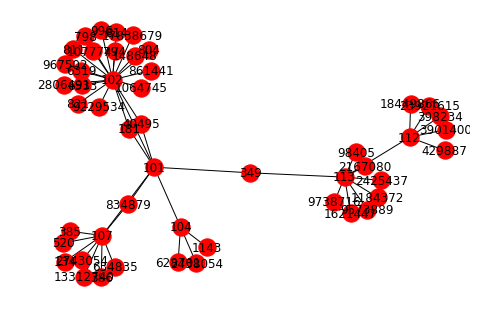

In [89]:
nx.draw(H, with_labels = True)

In [88]:
person = '101'

friends = set(H.neighbors(person))
fof = friends_of_friends_set(H, friends)
potential_friends = make_remove_set(H, person, fof)
recs = top_k_recs(H, friends, potential_friends, k=10)
format_recs(person, recs, k=10)

Top 10 friend recommendations for user 101:
#1: 1143
#2: 628701
#3: 148648
#4: 814
#5: 804
#6: 1064745
#7: 798
#8: 2438054
#9: 967502
#10: 811


## MapReduce

In [82]:
from mrjob.job import MRJob

In [84]:
class MRFriendsInCommon(MRJob):
    def mapper(line):
        parsed_line = ":".split(line)
        person = parsed_line[0]
        friends = parsed_line[1:]
        for friend in friends:
            pair = sorted(person, friends)
            yield pair, friends
            
    def reducer(pair, friends):
        friends_in_common = list(set(friends[0]).intersection(friends[1]))
        yield pair, friends_in_common